# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [5]:
# Display sample data
df.index = df.index.date
df.tail()

,AGG,SPY
,close,close
2019-12-24,112.375,321.26
2019-12-26,112.480,322.91
2019-12-27,112.620,322.86
2019-12-30,112.630,321.10
2019-12-31,112.370,321.92


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [6]:
# Calculate the daily roi for the stocks
df_daily_roi = df.pct_change()
# Display sample data
df_daily_roi.head()

,AGG,SPY
,close,close
2019-01-02,NaN,NaN
2019-01-03,0.004081,-0.021730
2019-01-04,-0.003037,0.032521
2019-01-07,-0.002109,0.007884
2019-01-08,-0.000470,0.008844


In [7]:
# Compute daily volatility
AGG_std = df_daily_roi.std()["AGG"]["close"]
SPY_std = df_daily_roi.std()["SPY"]["close"]

In [8]:
# Save the last day's closing price
AGG_last_close = df["AGG"]["close"][-1]
SPY_last_close = df["SPY"]["close"][-1]


In [9]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
AGG_avg_return = df_daily_roi.mean()["AGG"]["close"]
SPY_avg_return = df_daily_roi.mean()["SPY"]["close"]

In [10]:
# Run the Monte Carlo Simulation

#Initialize empty dataframe to hold simulated prices
simulated_prices_df = pd.DataFrame()
portfolio_cumulative_sim_returns = pd.DataFrame()

for n in range(number_simulations):
    
    #Initialize lists to hold simulated prices for each stock
    AGG_simulated_prices = [AGG_last_close]
    SPY_simulated_prices = [SPY_last_close]
    
    #Simulate prices
    for i in range(number_records):
        
        #Calculate simulated prices for each stock
        agg_simulated_price = AGG_simulated_prices[-1] * (1 + np.random.normal(AGG_avg_return, AGG_std))
        spy_simulated_price = SPY_simulated_prices[-1] * (1 + np.random.normal(SPY_avg_return, SPY_std))
        
        #Append simulated prices to the lists
        AGG_simulated_prices.append(agg_simulated_price)
        SPY_simulated_prices.append(spy_simulated_price)
        
    #Append simulations to the simulation df
    simulated_prices_df["AGG prices"] = pd.Series(AGG_simulated_prices)
    simulated_prices_df["SPY prices"] = pd.Series(SPY_simulated_prices)
    
    #Calculate simulated daily returns
    daily_returns_sim = simulated_prices_df.pct_change()
    
    #Set weights
    weights = [0.40, 0.60]
    
    #Calculate portfolio daily returns
    portfolio_daily_returns_sim = daily_returns_sim.dot(weights)
    
    #Calculate cumulative portfolio returns
    portfolio_cumulative_sim_returns[f"Simulation{n+1}"] = (1 + portfolio_daily_returns_sim.fillna(0)).cumprod()

In [11]:
# Check that the simulation ran successfully
portfolio_cumulative_sim_returns.tail()

,Simulation1,Simulation2,Simulation3,Simulation4,Simulation5,Simulation6,Simulation7,Simulation8,Simulation9,Simulation10,...,Simulation491,Simulation492,Simulation493,Simulation494,Simulation495,Simulation496,Simulation497,Simulation498,Simulation499,Simulation500
7556,192.198632,173.061915,175.536542,137.184495,174.087276,406.898297,103.715503,207.335040,179.851038,154.485316,...,205.794078,209.597094,201.019313,150.405526,211.474529,419.025393,175.585603,465.203342,135.029922,207.278177
7557,191.796295,171.335698,175.073322,137.168852,174.462336,406.829966,103.095585,209.131281,179.936157,153.301078,...,205.522019,208.967028,201.668852,149.199635,211.588511,421.932597,175.990087,466.851578,135.447343,206.876247
7558,191.217898,171.137531,175.864455,137.377557,173.873490,408.572982,103.151109,209.957651,180.769205,153.380322,...,205.679462,209.612623,202.344679,148.768826,212.614164,422.012395,176.024377,463.429554,134.469736,207.289917
7559,190.859975,171.029260,176.121496,137.739761,175.432388,406.560889,102.902693,209.654533,179.742836,153.250418,...,206.056113,210.666825,201.151747,148.821403,213.780900,421.115650,176.285521,462.220129,133.666973,206.401943
7560,192.769939,171.963857,177.992293,138.460439,175.622694,406.595515,102.234885,209.318807,178.367586,153.115371,...,206.850892,209.781981,200.644529,149.216748,214.329392,421.158099,176.158309,459.010501,134.125079,207.485372


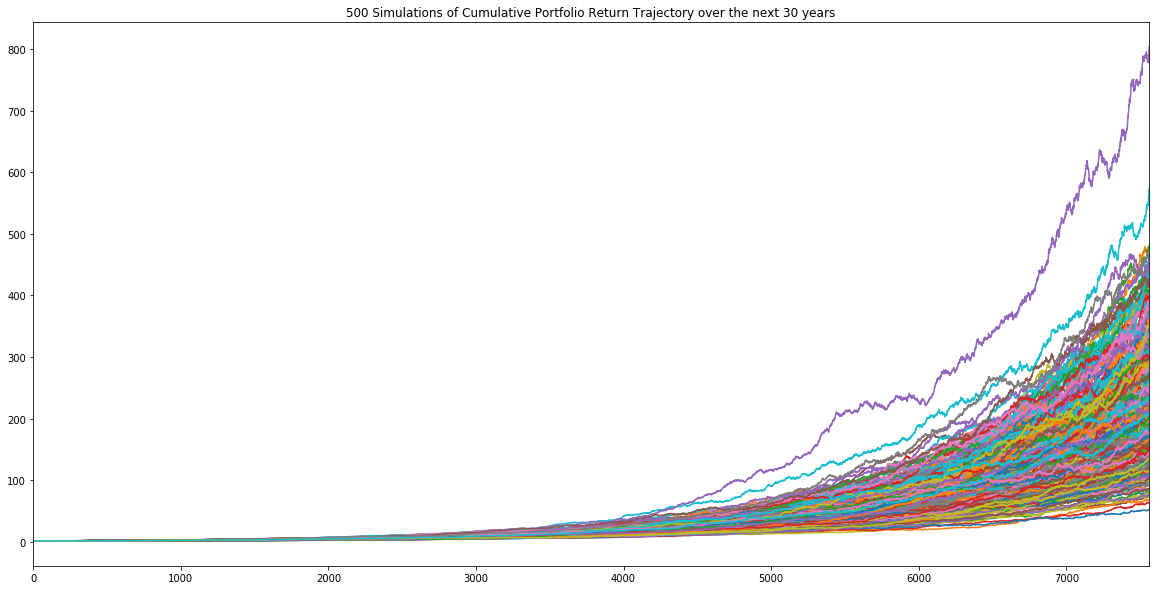

In [14]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectory over the next 30 years"
portfolio_cumulative_sim_returns.plot(legend=None, title=plot_title, figsize=(20,10))
plt.savefig('Simulations_portfolio_returns.png', bbox_inches="tight")

In [15]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns_sim = portfolio_cumulative_sim_returns.iloc[-1,:]
ending_cumulative_returns_sim.head()

Simulation1    192.769939
Simulation2    171.963857
Simulation3    177.992293
Simulation4    138.460439
Simulation5    175.622694
Name: 7560, dtype: float64

In [16]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns_sim.quantile(q=[0.05, 0.95])
confidence_interval

0.05    102.825245
0.95    379.342101
Name: 7560, dtype: float64

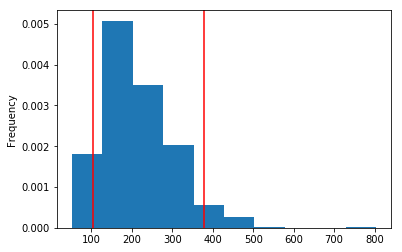

In [17]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns_sim.plot(kind="hist", density=True)
plt.axvline(confidence_interval.iloc[0], color="r")
plt.axvline(confidence_interval.iloc[1], color="r")
plt.savefig('Confidence_Interval.png', bbox_inches="tight")

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [18]:
# Compute cumulative returns
percentiles = ending_cumulative_returns_sim.quantile(q=[0.10, 0.50, 0.90])
percentiles

0.1    119.029858
0.5    199.089970
0.9    320.549831
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [19]:
# Set initial investment
initial_investment = 20000

# Calculate expected return at 10th, 50th and 90th percentiles
tenth_percentile_return = round((initial_investment * percentiles.iloc[0]), 2)
fiftieth_percentile_return = round((initial_investment * percentiles.iloc[1]), 2)
ninetieth_percentile_return = round((initial_investment * percentiles.iloc[2]), 2)

# Compute expected portfolio return
print(f"With an initial investment of $20,000 the expected return at the 10th percentile is: ${tenth_percentile_return}")
print(f"With an initial investment of $20,000 the expected return at the 50th percentile is: ${fiftieth_percentile_return}")
print(f"With an initial investment of $20,000 the expected return at the 90th percentile is: ${ninetieth_percentile_return}")

With an initial investment of $20,000 the expected return at the 10th percentile is: $2380597.16
With an initial investment of $20,000 the expected return at the 50th percentile is: $3981799.4
With an initial investment of $20,000 the expected return at the 90th percentile is: $6410996.62


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [20]:
# Set Plaid's projected income
projected_income = 6085

# Calculate the 4% withdrawal for the ending return as retirement income
withdrawal_amount = tenth_percentile_return*0.04

# Determine if the retirement income meets or exceeds the current projected income
if withdrawal_amount >= projected_income:
    print(f"The withdrawal amount is greater than your income, your funds are sufficient for retirement.")
    print(f"4% of your expected portfolio balance at the 10% percentile is {withdrawal_amount}")
else:
    print(f"The withdrawal amount is less than your income, your funds are insufficient for retirement")
    

The withdrawal amount is greater than your income, your funds are sufficient for retirement.
4% of your expected portfolio balance at the 10% percentile is 95223.8864


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [21]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
initial_investment_new = initial_investment * 1.5
tenth_percentile_return_new = round((initial_investment_new * percentiles.iloc[0]), 2)

# Calculate new withdrawal amount
withdrawal_amount_new = tenth_percentile_return_new * 0.04


#Compare new withdrawal amount to previous
print(f"The new 4% withdrawal amount is ${round((withdrawal_amount_new - withdrawal_amount),2)} higher than the previous amount.")


The new 4% withdrawal amount is $47611.94 higher than the previous amount.


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` percentiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [50]:
# Compute projected returns
fifth_percentile = (ending_cumulative_returns_sim.sort_values(ascending=False) <= 
             ending_cumulative_returns_sim.quantile(0.05)).idxmax()
fifth_percentile

'Simulation31'

In [51]:
fiftieth_percentile = (ending_cumulative_returns_sim.sort_values(ascending=False) <= 
             ending_cumulative_returns_sim.quantile(0.5)).idxmax()
fiftieth_percentile

'Simulation108'

In [68]:
ninety_fifth_percentile = (ending_cumulative_returns_sim.sort_values(ascending=False) <= 
             ending_cumulative_returns_sim.quantile(0.95)).idxmax()
ninety_fifth_percentile

'Simulation327'

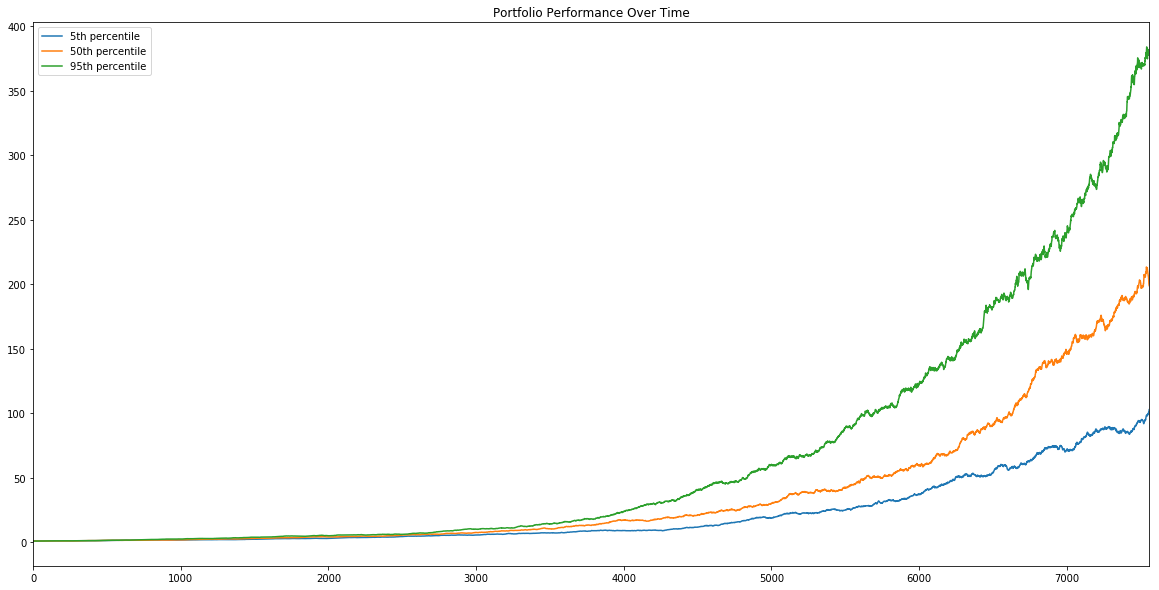

In [69]:
# Plot the cumulative returns over time
plot_title = "Portfolio Performance Over Time"

portfolio_cumulative_sim_returns[["Simulation31", "Simulation108", "Simulation327"]].plot(
    legend=legend, title=plot_title, figsize=(20,10))
plt.legend(["5th percentile", "50th percentile", "95th percentile"], loc='upper left')

plt.savefig('Portfolio_performance_over_time.png', bbox_inches="tight")

In [59]:
# Compute portfolio performance over time
median_return = (ending_cumulative_returns_sim.sort_values(ascending=False) <= 
             ending_cumulative_returns_sim.median()).idxmax()

ninetieth_percentile = (ending_cumulative_returns_sim.sort_values(ascending=False) <= 
             ending_cumulative_returns_sim.quantile(0.90)).idxmax()
ninetieth_percentile



'Simulation129'

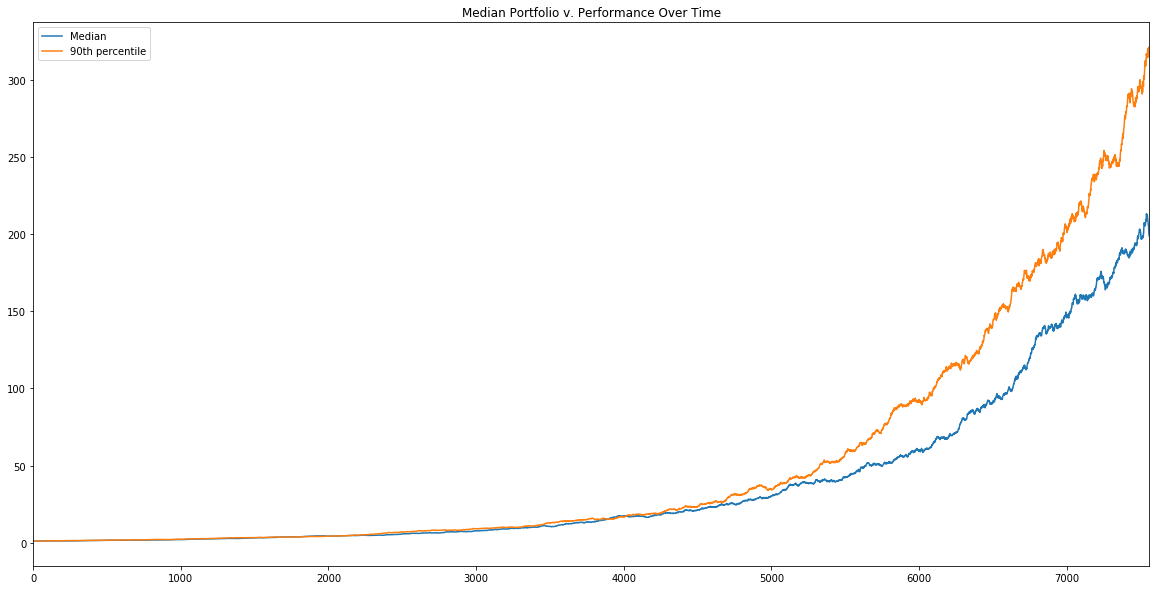

In [70]:
# Plot projected performance over time
plot_title = "Median Portfolio v. Performance Over Time"

portfolio_cumulative_sim_returns[["Simulation108", "Simulation129"]].plot(
    legend=legend, title=plot_title, figsize=(20,10))
plt.legend(["Median", "90th percentile"], loc='upper left')

plt.savefig('Median_Portfolio_performance_over_time.png', bbox_inches="tight")